# Overview
The following notebook outlines the process that one of our data scientists utilized to build a "segmentation" model for our marketing department.  The dependent variable is whether a customer purchased a product (y=1).or not (y=0). The implemented model will help the marketing department decide which customers receive an advertisement for the product.  

## Reading in the Libraries

In [1]:
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import sys
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
#loading visualization library
import bokeh

import collections as ccc

In [3]:
print("python version " + sys.version)
print('numpy version ' + np.__version__)
print('pandas version ' + pd.__version__)
print('sklern version ' + '0.23.1')
print('bokeh version ' + bokeh.__version__)
print('statsmodels version ' + '0.9.0')

python version 3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]
numpy version 1.19.5
pandas version 1.3.2
sklern version 0.23.1
bokeh version 2.3.3
statsmodels version 0.9.0


In [4]:
raw_train=pd.read_csv('exercise_26_train.csv')
raw_test=pd.read_csv('exercise_26_test.csv')
#Desribing the target variable
from collections import Counter
Counter(raw_train.y)

Counter({1: 19904, 0: 20096})

In [5]:
# Overview of data types
print("object dtype:", raw_train.columns[raw_train.dtypes == 'object'].tolist())
print("int64 dtype:", raw_train.columns[raw_train.dtypes == 'int'].tolist())
print("The rest of the columns have float64 dtypes.")

object dtype: ['x5', 'x12', 'x31', 'x63', 'x81', 'x82']
int64 dtype: []
The rest of the columns have float64 dtypes.


In [6]:
# Investigate Object Columns
def investigate_object(df):
    """
    This function prints the unique categories of all the object dtype columns.
    It prints '...' if there are more than 13 unique categories.
    """
    col_obj = df.columns[df.dtypes == 'object']

    for i in range(len(col_obj)):
        if len(df[col_obj[i]].unique()) > 13:
            print(col_obj[i]+":", "Unique Values:", np.append(df[col_obj[i]].unique()[:13], "..."))
        else:
            print(col_obj[i]+":", "Unique Values:", df[col_obj[i]].unique())
    
    del col_obj
investigate_object(raw_train)

x5: Unique Values: ['tuesday' 'saturday' 'thursday' 'sunday' 'wednesday' 'monday' 'friday']
x12: Unique Values: ['$6,882.34 ' '$5,647.81 ' '($5,032.58)' '($1,920.03)' '($5,859.08)'
 '$8,535.02 ' '$66.55 ' '$2,421.58 ' '($2,586.99)' '($4,324.44)'
 '($8,015.98)' '$2,669.04 ' '$1,729.51 ' '...']
x31: Unique Values: ['germany' 'asia' 'america' 'japan' nan]
x63: Unique Values: ['62.59%' '3.11%' '28.07%' '33.49%' '88.73%' '11.05%' '89.23%' '69.48%'
 '35.15%' '67.12%' '90.90%' '60.46%' '68.56%' '...']
x81: Unique Values: ['April' 'December' 'May' 'November' 'March' 'June' 'July' 'October'
 'January' 'February' 'August' 'September']
x82: Unique Values: ['Female' 'Male']


# Feature Engineering

In [7]:
train_val = raw_train.copy(deep=True)

#1. Fixing the money and percents#
train_val['x12'] = train_val['x12'].str.replace('$','')
train_val['x12'] = train_val['x12'].str.replace(',','')
train_val['x12'] = train_val['x12'].str.replace(')','')
train_val['x12'] = train_val['x12'].str.replace('(','-')
train_val['x12'] = train_val['x12'].astype(float)
train_val['x63'] = train_val['x63'].str.replace('%','')
train_val['x63'] = train_val['x63'].astype(float)

# 2. Creating the train/val/test set
x_train, x_val, y_train, y_val = train_test_split(train_val.drop(columns=['y']), train_val['y'], test_size=0.1, random_state=13)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=4000, random_state=13)

# 3. smashing sets back together
train = pd.concat([x_train, y_train], axis=1, sort=False).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1, sort=False).reset_index(drop=True)
test = pd.concat([x_test, y_test], axis=1, sort=False).reset_index(drop=True)

# 3. With mean imputation from Train set

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
train_imputed = pd.DataFrame(imputer.fit_transform(train.drop(columns=['y', 'x5', 'x31',  'x81' ,'x82'])), columns=train.drop(columns=['y', 'x5', 'x31', 'x81', 'x82']).columns)
std_scaler = StandardScaler()
train_imputed_std = pd.DataFrame(std_scaler.fit_transform(train_imputed), columns=train_imputed.columns)

# 3 create dummies

dumb5 = pd.get_dummies(train['x5'], drop_first=True, prefix='x5', prefix_sep='_', dummy_na=True)
train_imputed_std = pd.concat([train_imputed_std, dumb5], axis=1, sort=False)

dumb31 = pd.get_dummies(train['x31'], drop_first=True, prefix='x31', prefix_sep='_', dummy_na=True)
train_imputed_std = pd.concat([train_imputed_std, dumb31], axis=1, sort=False)

dumb81 = pd.get_dummies(train['x81'], drop_first=True, prefix='x81', prefix_sep='_', dummy_na=True)
train_imputed_std = pd.concat([train_imputed_std, dumb81], axis=1, sort=False)

dumb82 = pd.get_dummies(train['x82'], drop_first=True, prefix='x82', prefix_sep='_', dummy_na=True)
train_imputed_std = pd.concat([train_imputed_std, dumb82], axis=1, sort=False)
train_imputed_std = pd.concat([train_imputed_std, train['y']], axis=1, sort=False)

del dumb5, dumb31, dumb81, dumb82
train.head()

C:\Users\Asnakech\AppData\Local\Temp/ipykernel_8428/1717917025.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_val['x12'] = train_val['x12'].str.replace('$','')
C:\Users\Asnakech\AppData\Local\Temp/ipykernel_8428/1717917025.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_val['x12'] = train_val['x12'].str.replace(')','')
C:\Users\Asnakech\AppData\Local\Temp/ipykernel_8428/1717917025.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_val['x12'] = train_val['x12'].str.replace('(','-')


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-0.675304,0.137379,4.393917,-0.020123,-0.475619,sunday,0.157397,55.677997,1.836050,0.918460,...,0.406396,0.923903,3.190372,-99.480414,0.658721,1.017211,0.841947,-32.135482,-92.817959,1
1,-1.154193,0.491916,6.224052,0.911310,NaN,thursday,0.322901,67.982758,3.558598,0.968550,...,-0.213260,0.691155,3.513803,-102.807379,0.855491,1.523666,0.625777,-32.038531,-111.458616,0
2,-0.517891,5.329731,3.356213,-0.311618,-1.251960,saturday,0.429534,79.291691,3.668720,0.484290,...,-0.092073,0.984555,3.275413,-104.647167,1.114742,0.629985,0.443220,-32.529417,96.050527,0
3,-1.387908,3.731997,3.860884,-1.062690,-0.170879,sunday,0.673016,62.361178,4.003594,0.976110,...,-0.022378,0.518466,3.161572,-103.345848,0.116029,1.979604,0.658648,-32.175854,75.606195,0
4,0.079124,-1.802406,5.183612,0.801429,0.636439,friday,NaN,42.093272,4.263777,0.405445,...,-0.124459,0.364577,NaN,-90.521508,1.056957,1.293643,0.243751,-32.564535,21.057102,1


In [8]:
#Showing the imputer statistics
imputer.statistics_

array([ 7.92229931e-04, -1.00645489e-02,  4.99964676e+00,  1.41831121e-03,
        4.93924244e-03,  5.00363576e-01,  5.00408689e+01,  2.50906048e+00,
        4.98037746e-01,  1.44968823e+01, -1.00062564e+00,  2.04852884e+01,
        4.99312723e-01,  2.49398483e+01,  5.21042421e-01,  4.98721665e-01,
        1.45017479e+01, -2.00022871e+01,  4.98149710e-01,  1.24833757e-01,
       -3.51584541e-02,  5.01571313e-01,  3.50017149e+00, -9.99264396e+01,
        7.51218322e-01,  2.50959339e+00,  4.99573809e-01,  1.45005206e+01,
       -1.00944689e+00,  5.00258855e+00,  4.99455396e-01,  2.50064264e+00,
       -1.60173697e+00,  9.48489867e-01, -5.00485651e-01,  3.50071828e+00,
       -1.50197839e+00, -1.00357228e+00,  1.54335146e+00,  1.52266682e+01,
        5.17458033e+00,  8.60583320e+00,  5.00565465e-01, -8.25609536e-04,
       -2.43701265e-03,  2.89563910e-03, -1.88721614e-03, -2.45598108e-03,
       -2.46846377e-03,  2.87215906e-03, -7.76626320e-03,  4.00117940e-01,
        1.85134565e-03, -

In [9]:
#Showing the variance
train_imputed.var()

x0        1.009929
x1        8.916178
x2        0.988932
x3        0.979721
x4        0.973921
          ...     
x95       0.184415
x96       0.721085
x97       0.081038
x98       0.082531
x99    9914.189604
Length: 96, dtype: float64

# Visualizing the Correlations
As part of the exploratory analysis, we want to look at a heatmap to see if there are any high pairwise correlations.  If we see a few number of variables correlated with the target, then we will use an L2 penalty.  If we see a lot of variables correlated with y then we will use an L2 penalty.

matplotlib version 3.4.3
seaborn version 0.11.2


<AxesSubplot:>

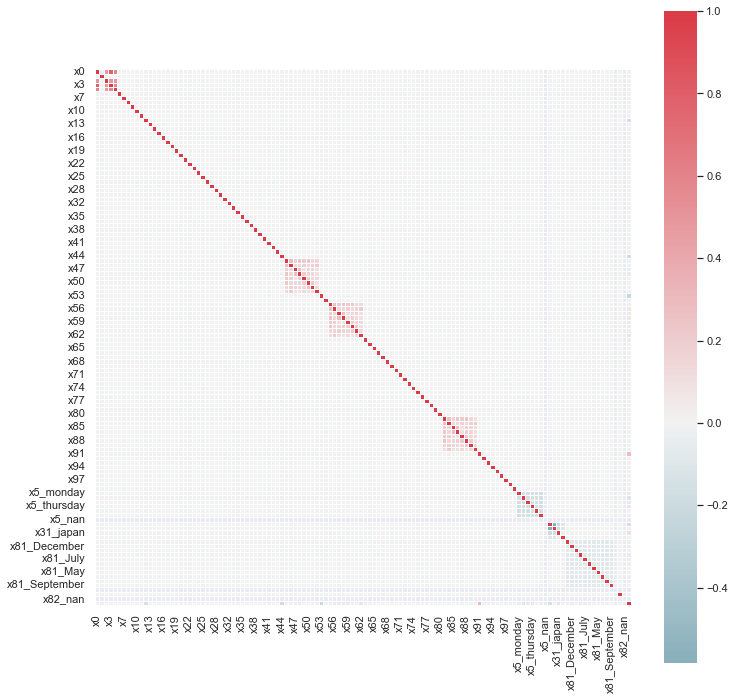

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
print("matplotlib version " + matplotlib.__version__)
print("seaborn version " + sns.__version__)
sns.set(style='white')

corr = train_imputed_std.corr()

plt.figure(figsize=(12,12))
sns.set(font_scale=1)
sns.heatmap(data=corr,
            center=0,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, linewidth=0.5)

# Initial Feature Selection
Looking at the correlation map from above, we can see there are very few variables associated with the dependent variable.  Thus, we will use an L1 penalty to for feature selection. Interestingly enough, we see a that some variables have heavy correlation amongst themselves. 

In [11]:
exploratory_LR = LogisticRegression(penalty='l1', fit_intercept=False, solver='liblinear')
exploratory_LR.fit(train_imputed_std.drop(columns=['y']), train_imputed_std['y'])
exploratory_results = pd.DataFrame(train_imputed_std.drop(columns=['y']).columns).rename(columns={0:'name'})
exploratory_results['coefs'] = exploratory_LR.coef_[0]
exploratory_results['coefs_squared'] = exploratory_results['coefs']**2
var_reduced = exploratory_results.nlargest(25,'coefs_squared')

# Preliminary Model
## Starting with the train set
The L1 process creates biased parameter estimates.  As a result, we will build a final model without biased estimators. 

In [12]:
variables = var_reduced['name'].to_list()
logit = sm.Logit(train_imputed_std['y'], train_imputed_std[variables])
# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.536381
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                32000
Model:                          Logit   Df Residuals:                    31975
Method:                           MLE   Df Model:                           24
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.2262
Time:                        23:46:22   Log-Likelihood:                -17164.
converged:                       True   LL-Null:                       -22181.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
x5_saturday      -1.1834      0.041    -29.039      0.000      -1.263      -1.104
x81_July          1.1139      0.053     20.893      0.000       1.009       1.218
x81_December      1.0501      0.053     19.917      0.000       0.947       1.153
x31_japan         0.8994      0.062     14.413      0.000       0.777       1.022
x81_October       0.9262      0.052     17.783      0.000       0.824       1.028
x5_sunday        -0.8408      0.040    -21.038      0.000      -0.919      -0.762
x31_asia         -0.7802      0.033    -23.443      0.000      -0.845      -0.715
x81_February      0.8670      0.052     16.658      0.000       0.765       0.969
x91               0.7682      0.014     54.253      0.000       0.740       0.796
x81_May           0.8104      0.053     15.371      0.000       0.707       0.914
x5_monday        -0.7022      0.040    -17.632      0.000      -0.780      -0.624
x81_September     0.7231      0.052     13.877      0.000       0.621       0.825
x81_March         0.7081      0.052     13.531      0.000       0.606       0.811
x53              -0.6197      0.014    -44.860      0.000      -0.647      -0.593
x81_November      0.5808      0.052     11.167      0.000       0.479       0.683
x44              -0.5085      0.014    -37.333      0.000      -0.535      -0.482
x81_June          0.4664      0.052      8.913      0.000       0.364       0.569
x12              -0.3964      0.013    -29.531      0.000      -0.423      -0.370
x5_tuesday       -0.3945      0.040     -9.950      0.000      -0.472      -0.317
x81_August        0.4463      0.053      8.496      0.000       0.343       0.549
x81_January       0.3726      0.052      7.121      0.000       0.270       0.475
x62              -0.2828      0.014    -20.604      0.000      -0.310      -0.256
x31_germany      -0.1699      0.033     -5.157      0.000      -0.235      -0.105
x58               0.2046      0.014     15.151      0.000       0.178       0.231
x56               0.1978      0.014     14.404      0.000       0.171       0.225
=================================================================================
"""

## Prepping the validation set

In [13]:
val_imputed = pd.DataFrame(imputer.transform(val.drop(columns=['y', 'x5', 'x31', 'x81' ,'x82'])), columns=train.drop(columns=['y','x5', 'x31', 'x81', 'x82']).columns)
val_imputed_std = pd.DataFrame(std_scaler.transform(val_imputed), columns=train_imputed.columns)

dumb5 = pd.get_dummies(val['x5'], drop_first=True, prefix='x5', prefix_sep='_', dummy_na=True)
val_imputed_std = pd.concat([val_imputed_std, dumb5], axis=1, sort=False)

dumb31 = pd.get_dummies(val['x31'], drop_first=True, prefix='x31', prefix_sep='_', dummy_na=True)
val_imputed_std = pd.concat([val_imputed_std, dumb31], axis=1, sort=False)

dumb81 = pd.get_dummies(val['x81'], drop_first=True, prefix='x81', prefix_sep='_', dummy_na=True)
val_imputed_std = pd.concat([val_imputed_std, dumb81], axis=1, sort=False)

dumb82 = pd.get_dummies(val['x82'], drop_first=True, prefix='x82', prefix_sep='_', dummy_na=True)
val_imputed_std = pd.concat([val_imputed_std, dumb82], axis=1, sort=False)
val_imputed_std = pd.concat([val_imputed_std, val['y']], axis=1, sort=False)

val_imputed_std.head()

,x0,x1,x2,x3,x4,x6,x7,x8,x9,x10,...,x81_June,x81_March,x81_May,x81_November,x81_October,x81_September,x81_nan,x82_Male,x82_nan,y
0,-0.231911,0.186734,-0.438440,0.447099,-0.480048,1.413353,-1.203852,-0.506744,0.543303,1.425218,...,0,0,0,0,0,0,0,0,0,1
1,1.017748,-1.006176,0.543572,0.544661,-0.391593,-0.064206,-0.768629,-0.571327,0.177188,1.255437,...,0,0,0,0,0,0,0,0,0,0
2,-1.370613,-0.483136,0.319564,0.115143,-0.164072,1.150836,1.707546,1.392168,-0.986833,0.396749,...,0,0,0,0,1,0,0,0,0,1
3,0.416365,-0.400150,0.874787,-1.184976,-0.109468,-0.825217,-0.961963,0.236944,1.588518,-0.142784,...,0,0,1,0,0,0,0,0,0,0
4,1.083974,0.388143,0.799889,1.336362,1.258094,1.453268,0.348362,1.704476,-0.577322,-0.503365,...,0,1,0,0,0,0,0,1,0,1


## Prepping the test set

In [14]:
test_imputed = pd.DataFrame(imputer.transform(test.drop(columns=['y', 'x5', 'x31', 'x81' ,'x82'])), columns=train.drop(columns=['y','x5', 'x31', 'x81', 'x82']).columns)
test_imputed_std = pd.DataFrame(std_scaler.transform(test_imputed), columns=train_imputed.columns)

# 3 create dummies

dumb5 = pd.get_dummies(test['x5'], drop_first=True, prefix='x5', prefix_sep='_', dummy_na=True)
test_imputed_std = pd.concat([test_imputed_std, dumb5], axis=1, sort=False)

dumb31 = pd.get_dummies(test['x31'], drop_first=True, prefix='x31', prefix_sep='_', dummy_na=True)
test_imputed_std = pd.concat([test_imputed_std, dumb31], axis=1, sort=False)

dumb81 = pd.get_dummies(test['x81'], drop_first=True, prefix='x81', prefix_sep='_', dummy_na=True)
test_imputed_std = pd.concat([test_imputed_std, dumb81], axis=1, sort=False)

dumb82 = pd.get_dummies(test['x82'], drop_first=True, prefix='x82', prefix_sep='_', dummy_na=True)
test_imputed_std = pd.concat([test_imputed_std, dumb82], axis=1, sort=False)
test_imputed_std = pd.concat([test_imputed_std, test['y']], axis=1, sort=False)

In [15]:
val_imputed_std.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9', 'x10',
       ...
       'x81_June', 'x81_March', 'x81_May', 'x81_November', 'x81_October',
       'x81_September', 'x81_nan', 'x82_Male', 'x82_nan', 'y'],
      dtype='object', length=122)

In [16]:
Outcomes_train = pd.DataFrame(result.predict(train_imputed_std[variables])).rename(columns={0:'probs'})
Outcomes_train['y'] = train_imputed_std['y']
print('The C-Statistics is ',roc_auc_score(Outcomes_train['y'], Outcomes_train['probs']))
Outcomes_val = pd.DataFrame(result.predict(val_imputed_std[variables])).rename(columns={0:'probs'})
Outcomes_val['y'] = val_imputed_std['y']
print('The C-Statistics is ',roc_auc_score(Outcomes_val['y'], Outcomes_val['probs']))
Outcomes_test = pd.DataFrame(result.predict(test_imputed_std[variables])).rename(columns={0:'probs'})
Outcomes_test['y'] = test_imputed_std['y']
print('The C-Statistics is ',roc_auc_score(Outcomes_test['y'], Outcomes_test['probs']))
Outcomes_train['prob_bin'] = pd.qcut(Outcomes_train['probs'], q=20)

Outcomes_train.groupby(['prob_bin'])['y'].sum()

The C-Statistics is  0.8011821329279427
The C-Statistics is  0.7981369915910524
The C-Statistics is  0.8021842765709619


prob_bin
(0.0026, 0.0817]      29
(0.0817, 0.128]      172
(0.128, 0.172]       267
(0.172, 0.216]       391
(0.216, 0.26]        416
(0.26, 0.303]        538
(0.303, 0.348]       578
(0.348, 0.395]       675
(0.395, 0.44]        660
(0.44, 0.487]        775
(0.487, 0.531]       844
(0.531, 0.577]       893
(0.577, 0.621]       934
(0.621, 0.667]      1011
(0.667, 0.713]      1056
(0.713, 0.759]      1162
(0.759, 0.806]      1228
(0.806, 0.854]      1344
(0.854, 0.906]      1445
(0.906, 0.995]      1577
Name: y, dtype: int64

# Finalizing the Model
In the code above, we identified that the model generalized well; the AUC was similar for each of the partitions of the training data.  Moving forward, we want to 
1. refit the model using all of the training data
2. check the coefficients against the preliminary model
3. assess the lift and ask for a cutoff from the business partner.

In [17]:
train_and_val = pd.concat([train_imputed_std, val_imputed_std])
all_train = pd.concat([train_and_val, test_imputed_std])
variables = var_reduced['name'].to_list()
final_logit = sm.Logit(all_train['y'], all_train[variables])
# fit the model
final_result = final_logit.fit()
final_result.summary()

Optimization terminated successfully.
         Current function value: 0.536475
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39975
Method:                           MLE   Df Model:                           24
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.2260
Time:                        23:46:23   Log-Likelihood:                -21459.
converged:                       True   LL-Null:                       -27725.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
x5_saturday      -1.2065      0.037    -32.949      0.000      -1.278      -1.135
x81_July          1.0958      0.047     23.090      0.000       1.003       1.189
x81_December      1.0294      0.047     21.812      0.000       0.937       1.122
x31_japan         0.9249      0.056     16.540      0.000       0.815       1.035
x81_October       0.9111      0.047     19.516      0.000       0.820       1.003
x5_sunday        -0.8573      0.036    -23.921      0.000      -0.928      -0.787
x31_asia         -0.7595      0.030    -25.522      0.000      -0.818      -0.701
x81_February      0.8253      0.047     17.645      0.000       0.734       0.917
x91               0.7660      0.013     60.549      0.000       0.741       0.791
x81_May           0.7930      0.047     16.837      0.000       0.701       0.885
x5_monday        -0.6696      0.035    -18.935      0.000      -0.739      -0.600
x81_September     0.6814      0.047     14.630      0.000       0.590       0.773
x81_March         0.6835      0.047     14.664      0.000       0.592       0.775
x53              -0.6221      0.012    -50.365      0.000      -0.646      -0.598
x81_November      0.5608      0.047     12.039      0.000       0.470       0.652
x44              -0.5058      0.012    -41.482      0.000      -0.530      -0.482
x81_June          0.4448      0.047      9.537      0.000       0.353       0.536
x12              -0.3938      0.012    -32.788      0.000      -0.417      -0.370
x5_tuesday       -0.3727      0.035    -10.505      0.000      -0.442      -0.303
x81_August        0.4300      0.047      9.162      0.000       0.338       0.522
x81_January       0.3457      0.047      7.373      0.000       0.254       0.438
x62              -0.2882      0.012    -23.503      0.000      -0.312      -0.264
x31_germany      -0.1664      0.029     -5.649      0.000      -0.224      -0.109
x58               0.2107      0.012     17.516      0.000       0.187       0.234
x56               0.2002      0.012     16.356      0.000       0.176       0.224
=================================================================================
"""

In [18]:
Outcomes_train_final = pd.DataFrame(result.predict(all_train[variables])).rename(columns={0:'probs'})
Outcomes_train_final['y'] = all_train['y']
print('The C-Statistics is ',roc_auc_score(Outcomes_train_final['y'], Outcomes_train_final['probs']))
Outcomes_train_final['prob_bin'] = pd.qcut(Outcomes_train_final['probs'], q=20)
Outcomes_train_final.groupby(['prob_bin'])['y'].sum()

The C-Statistics is  0.8010042026368287


prob_bin
(0.0026, 0.0824]      43
(0.0824, 0.128]      206
(0.128, 0.172]       317
(0.172, 0.215]       479
(0.215, 0.259]       517
(0.259, 0.303]       674
(0.303, 0.348]       732
(0.348, 0.394]       835
(0.394, 0.439]       836
(0.439, 0.485]       949
(0.485, 0.53]       1036
(0.53, 0.575]       1102
(0.575, 0.62]       1184
(0.62, 0.666]       1261
(0.666, 0.712]      1330
(0.712, 0.758]      1438
(0.758, 0.805]      1530
(0.805, 0.854]      1658
(0.854, 0.906]      1804
(0.906, 0.995]      1973
Name: y, dtype: int64

In [19]:
import joblib
joblib.dump(result, 'model.pkl')


['model.pkl']

In [20]:
lr = joblib.load('model.pkl')

In [21]:
lr.predict((all_train[variables]))

0       0.724294
1       0.141294
2       0.231141
3       0.584832
4       0.328788
          ...   
3995    0.456982
3996    0.833763
3997    0.826610
3998    0.381458
3999    0.434764
Length: 40000, dtype: float64

In [22]:
raw_train[0:3].to_dict(orient='records')

[{'x0': -1.018506,
  'x1': -4.180869,
  'x2': 5.703058724,
  'x3': -0.522021597,
  'x4': -1.678553956,
  'x5': 'tuesday',
  'x6': 0.18617,
  'x7': 30.162959,
  'x8': 1.200073,
  'x9': 0.373124,
  'x10': 14.973894,
  'x11': -0.81238,
  'x12': '$6,882.34 ',
  'x13': 0.078341,
  'x14': 32.823072,
  'x15': 0.02048,
  'x16': 0.171077,
  'x17': 14.236199,
  'x18': -18.646051,
  'x19': 0.575313,
  'x20': 0.068703,
  'x21': -0.276702,
  'x22': 0.754378,
  'x23': 3.103192,
  'x24': -101.889723,
  'x25': 1.49565,
  'x26': 3.412199,
  'x27': 0.601394,
  'x28': 14.210012,
  'x29': 0.558285,
  'x30': 4.21066,
  'x31': 'germany',
  'x32': 0.07303966,
  'x33': 2.99793546,
  'x34': -1.91981754,
  'x35': 1.11327381,
  'x36': -0.75988365,
  'x37': 3.00740356,
  'x38': -1.76639977,
  'x39': -1.93067723,
  'x40': 288.2,
  'x41': 129.79,
  'x42': 366.71,
  'x43': -1134.56,
  'x44': 0.98441208,
  'x45': 1.10833973,
  'x46': 0.495749506,
  'x47': 0.422930348,
  'x48': 1.628712455,
  'x49': 0.402797858,
  'x5

In [23]:
raw_train['x12'].to_list()

['$6,882.34 ',
 '$5,647.81 ',
 '($5,032.58)',
 '($1,920.03)',
 '($5,859.08)',
 '$8,535.02 ',
 '$66.55 ',
 '$2,421.58 ',
 '($2,586.99)',
 '($4,324.44)',
 '($8,015.98)',
 '$2,669.04 ',
 '$1,729.51 ',
 '$4,031.57 ',
 '($4,739.70)',
 '($1,142.44)',
 '$1,856.93 ',
 '($7,415.60)',
 '($958.87)',
 '($8,048.51)',
 '($4,649.48)',
 '($8,152.05)',
 '($9,794.00)',
 '$549.77 ',
 '$2,361.91 ',
 '($4,753.87)',
 '$8,196.92 ',
 '($2,629.66)',
 '$5,205.91 ',
 '($7,160.17)',
 '($4,592.41)',
 '$2,956.17 ',
 '($5,472.80)',
 '$5,397.61 ',
 '($9,083.45)',
 '$4,668.61 ',
 '($890.28)',
 '($5,198.57)',
 '$2,907.72 ',
 '($8,188.85)',
 '$9,728.25 ',
 '$1,807.40 ',
 '$5,286.63 ',
 '$1,543.19 ',
 '($4,481.70)',
 '($2,949.96)',
 '$8,452.63 ',
 '$9,129.74 ',
 '($8,457.88)',
 '$7,374.81 ',
 '$3,939.79 ',
 '$8,484.23 ',
 '($5,452.39)',
 '($3,835.85)',
 '$6,643.63 ',
 '$5,644.76 ',
 '($5,464.16)',
 '($8,594.92)',
 '$2,770.24 ',
 '$9,620.74 ',
 '$7,088.53 ',
 '$9,530.80 ',
 '($7,326.47)',
 '($5,322.43)',
 '($8,942.18)',
 

In [25]:
raw_train['x12'][3]

'($1,920.03)'

## Debrief
In the final discussion with the business partner, the partner was thrilled with the rank-order ability of the model.  Based on a combination of capacity and accuracy, the partner would like to classify any observation that would fall in the top 5 bins as an event; for simplicity we will say the cutoff is at the 75th percentile.  For the API, please return the predicted outcome (variable name is business_outcome), predicted probability (variable name is phat), and all model inputs; the variables should be returned in alphabetical order in the API return.

In [27]:
count(raw_test.isnull())

NameError: name 'count' is not defined

In [38]:
raw_test.loc[40:50]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
40,-0.523101,2.275602,3.754982,-0.106930,-0.217194,thursday,0.078430,89.311128,1.476233,0.806078,...,0.220958,0.495968,0.338928,3.320652,-97.974614,0.531580,2.110651,0.303004,-32.149100,-97.579605
41,1.104201,-2.776344,5.883434,1.024876,1.205901,tuesday,0.587524,99.958788,4.301910,0.990660,...,-0.072720,-0.018800,0.242971,3.852697,-102.761275,0.642719,1.085126,0.541358,-32.143162,25.943535
42,-0.607311,-3.518526,5.565363,-0.821731,-1.728655,saturday,0.846181,51.687079,2.026595,0.589799,...,0.534383,0.353912,0.738943,3.749100,-99.738314,0.882109,1.674240,0.911934,-32.592762,-96.136795
43,0.862724,NaN,4.201887,0.769348,-0.547643,friday,0.353774,27.573393,2.086864,0.853675,...,0.713428,0.431285,0.642226,3.829427,-99.838859,0.823032,0.489782,0.795787,-32.895139,74.945459
44,0.866772,1.625997,4.652249,-0.095572,0.170623,wednesday,0.569917,79.940311,3.847423,0.003205,...,1.086710,0.340720,0.051932,3.513047,-92.444880,1.065233,0.427499,0.018810,-32.955292,133.612830
45,0.004587,-1.160745,4.371889,0.696466,0.715074,wednesday,0.352523,22.400369,0.305541,0.152950,...,0.075914,-0.194444,0.682277,3.616598,-103.431343,0.114625,0.977669,0.297915,-32.297376,-107.140948
46,-1.474356,-0.455409,5.180000,-1.510993,0.198503,monday,0.567422,36.932697,NaN,0.072833,...,0.536491,0.277574,0.800607,3.142092,-94.376828,1.484422,2.773525,0.429390,-32.688525,54.592915
47,-0.015317,-0.524844,5.312011,-0.524731,-0.165011,wednesday,0.299259,46.731210,1.575063,0.547241,...,0.912721,-0.133617,0.344455,3.356977,-102.949977,0.598214,1.804132,0.947606,-32.487893,91.866522
48,NaN,-1.208769,5.329129,0.586287,0.556395,saturday,0.892233,39.143882,1.466424,0.084830,...,-0.577882,0.213661,0.662324,3.847535,-101.303169,0.253694,2.195676,0.848589,-32.585866,-146.087130
49,0.930688,6.270810,6.621069,0.110379,-0.465153,thursday,0.052577,55.296106,3.087388,0.830511,...,-0.023632,0.654142,0.091970,3.781986,-96.052178,0.468703,0.808657,0.082410,-32.628078,75.479589


In [32]:
raw_test

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,0.042317,-3.344721,4.635124,-0.598396,-0.647772,monday,0.184902,46.690015,3.034132,0.364704,...,-0.493304,0.373853,0.941435,3.546798,-99.857488,0.403926,1.653787,0.007715,-32.021646,-60.312783
1,-1.033160,-0.340140,5.871823,NaN,0.122133,tuesday,0.997773,51.581411,1.709219,0.844079,...,0.521119,0.148424,0.925301,3.830426,-101.105748,0.055775,0.564890,0.051716,-32.540612,-266.725795
2,2.029367,-3.239301,4.724436,2.211831,0.551611,tuesday,0.492405,87.179042,4.333755,0.513789,...,0.154492,-0.034504,0.904042,3.642968,-107.476487,1.046718,1.494123,0.231084,-32.740954,-4.327887
3,-0.065676,1.892277,4.818741,0.640313,1.944562,friday,0.208718,73.573314,4.929132,0.116004,...,0.305243,-0.099213,0.712234,3.853489,-91.650053,0.499861,2.804358,0.627921,-32.190043,103.192597
4,-0.357126,-1.852161,5.367849,-0.069869,-0.641455,saturday,0.940286,72.773335,NaN,0.191044,...,0.617258,0.307445,0.376738,3.306958,-99.557140,1.275527,1.476482,0.122798,-32.957087,-111.509168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.261591,1.436751,5.609435,-0.214122,-0.036072,monday,0.538101,94.051371,0.128483,0.831800,...,0.629069,0.465482,0.096421,3.577037,-98.673736,0.465537,0.723919,0.966914,-32.278775,-0.225136
9996,-2.006043,-3.135000,4.680411,-1.722245,-0.955550,friday,0.091303,76.540749,NaN,0.788643,...,1.887403,0.438610,0.843943,3.486823,-106.188958,0.838675,1.361103,0.777474,-32.308340,102.043779
9997,0.726709,0.960993,6.504909,1.263968,1.135526,wednesday,0.901729,73.040847,3.763917,0.428526,...,-0.892807,0.373674,0.533687,3.926538,-87.777630,0.019378,1.323227,0.946826,-32.745950,102.891836
9998,-0.717903,0.716265,5.178784,-0.504802,0.011045,sunday,0.662930,9.958968,0.651211,0.321436,...,-0.248373,0.340834,0.428005,3.352950,-107.147221,0.231888,1.647653,0.935385,-32.986826,-70.842760
